# CSPB 3202 Final Project #

Tyler Kinkade, jaki9292@colorado.edu

GitHub: [https://github.com/jaki9292/rl-project](https://github.com/jaki9292/rl-project)

## Overview ##

This write-up reports on a small project to compare the effectiveness of reinforcement learning algorithms (Russell & Norvig, 2022; Sutton & Barto, 2018) within the Gymnasium (2022) "lunar lander" environment.

The report is divided into the following sections: approach, results, discussion, and suggestions.

## Approach ##

This section is divided into the following subsections: environment, models, methods.

### Environment ###

The lunar lander environment (pictured below) simulates rocket trajectory physics with the primary aim of landing a lunar lander on a central landing pad (marked by two flags) by means of turning its three rockets thrusters(left, right, and main) on or off. The agent operating the lander is rewarded for landing slowly, in an upright position, on both legs, on or near the landing pad and penalized otherwise. Fuel is unlimited, but a penalty is made for each time an engine fires. Scores of 200 points or more are considered a solution. 

The state space is described by an 8-vector comprised of the lander coordinates $(x,y)$, its linear velocities $(v_x,v_y)$ in the $x$ and $y$ directions, its angle $(\theta)$, its angular velocity $(\omega)$, and two Boolean variables $(l,r)$ for whether the left and right legs are in contact with the ground. The environment has both discrete and continuous versions, but only the discrete version is used here, in order to include simple models in the comparison. The environment gravity, wind power, and turbulence can also be specified. The starting state is the top center with a random force to it. The termination state occurs when the lander stops moving or moves outside the frame. The action space is comprised of 4 discrete actions: do nothing, fire left thruster, fire main down thruster, or fire right thruster.

In [1]:
# Display Lunar Lander GIF
from IPython.display import Image
Image(url= "https://gymnasium.farama.org/_images/lunar_lander.gif")

In [2]:
# Print environment parameters
# References: 
# https://gymnasium.farama.org/api/env/
# https://gymnasium.farama.org/environments/box2d/lunar_lander/

# Install dependencies
# pip install gymnasium
# pip install gymnasium[box2d]

import gymnasium as gym

# Initialize environment
env = gym.make("LunarLander-v2", 
               continuous = False,      # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array") # Render for machine

env.reset()

print("Environment metadata:\n", env.metadata)
print("\nState space:\n", env.observation_space)
print("\nAction space:\n", env.action_space)

Environment metadata:
 {'render_modes': ['human', 'rgb_array'], 'render_fps': 50}

State space:
 Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)

Action space:
 Discrete(4)


Thus, the bounds of the state attributes are:
| Attribute | Lower | Upper | Units |
| --------- | :---: | :---: | ----- |
| position $(x,y)$ | $-90$ | $90$ | units |
| linear velocity $(v_x,v_y)$| $-5$ | $5$ | units/sec |
| angle $(\theta)$| $-\pi$ | $\pi$ | radians |
| angular velocity $(\omega)$ | $-5$ | $5$ | radians/sec* |
| legs on ground $(l,r)$ | $0$ | $1$ | Boolean |

\* According to the [Gymnasium (2022) documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/#notes): "The angular velocity is in units of 0.4 radians per second. In order to convert to radians per second, the value needs to be multiplied by a factor of 2.5."

### Models ###

Four models are compared in this project: a random agent, a simple reflex agent, a Q-learning agent, and an approximate reinforcement learning agent (Russell & Norvig, 2022; Sutton & Barto, 2018). 

A random agent selects any of the possible actions uniformly randomly at each step without regard to the environment. The animation above is an example of such an agent, which is obviously a poor strategy. 

A simple reflex agent can only react in a fixed way to sensory input but does not retain any memory of the past and, as a result, cannot learn. 

A Q-learning agent alternates between learning through exploration and exploiting what it has learned by choosing the optimal policy for each state. Although this is obviously better than the relatively ignorant reflex agent, Q-learning agents can quickly become computationally expensive and slow to learn in large and complex environments. 

An approximate reinforcement learning agent is meant to address this issue by approximating a Q-learning agent through the use of a weighted linear approximation of the Q-values which it learns through exploration a certain amount of the time. Theoretically, this should simplify the computational demands.

It is expected that the last two models will perform better than the first two; however, it is possible that some difficulties might arise with the two learning agents. The environment might be too complex for the Q-learning agent to learn within a reasonable time. It is also possible that approximating the optimal choices may be insufficient. 

### Methods ###

Each model will be run for 10,000 time-steps (approximately 100 episodes) and their scores over each of the episodes will be plotted and compared. Visualizing each models' performance over successive episodes permits comparison of how each agent progressed in learning how to solve the model. This is preferable to single metrics, such as maximum or average scores which can conceal important distinctions. For example, we can discover whether an agent achieved a maximum only once, but performed poorly most of the time. Similarly, an average score can conceal unstable, fluctuating performance. Ideally, we would like to see an agent learning quickly and then stably maintaining scores over the solution threshold of 200 points.

Through this methodology, we will be able to explore the advantages and disadvantages of various models and demonstrate how a solution to the problem can be explored through the modfication of features and comparison of models.

## Results ## 

show the result and interpretation of your experiment. Any iterative improvements summary. demo clips
Does it include the results summary, interpretation of experiments and visualization (e.g. performance comparison table, graphs etc)?

In this section, I compare the four different models: a random agent, a simple reflex agent, a Q-learning agent, and an approximate reinforcement learning agent.

### Random Agent ###

As previously mentioned, the random agent selects any of the four actions randomly at each step.

In [ ]:
# Run and record random agent in lunar lander environment
# References: 
# https://gymnasium.farama.org/
# https://gymnasium.farama.org/api/utils/#save-rendering-videos
# https://gymnasium.farama.org/environments/box2d/lunar_lander/
# https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

# Install dependencies
# pip install gymnasium
# pip install gymnasium[box2d]
# pip install moviepy

import gymnasium as gym
from gymnasium.utils.save_video import save_video
import numpy as np
from IPython.utils.capture import capture_output

# Initialize environment
env = gym.make("LunarLander-v2", 
               continuous = False,          # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array_list") # Render for machine

# Reset environment with random number generator seed for reproducibility
observation, info = env.reset(seed = 21)

# Accumulator variables
score = 0.0
scores = []
episode = 0
step_start_index = 0

# Attempt for 10,000 timesteps
for step_index in range(10000):

     # Get random action from action space
    action = env.action_space.sample()

    # Obtain observation, reward, terminated status, truncated status, 
    # and environment info for given action
    observation, reward, terminated, truncated, info = env.step(action)

    # Accumulate reward total 
    score += reward

    # If episode ends
    if terminated or truncated:
        # Append total to list of reward totals
        scores.append(score)

        # Report result
        print(f"Episode {episode} score: {score}")

        # Suppress MoviePy stdout
        # https://stackoverflow.com/a/35624406/14371011
        with capture_output() as captured:
            # Save mp4 video of every (k^3)th (i.e., 0, 1, 8, 27, ...)
            save_video(env.render(),
                    video_folder = "videos",
                    name_prefix = "random_agent",
                    fps = env.metadata["render_fps"],
                    step_starting_index = step_start_index,
                    episode_index = episode)

        # Increment episode
        episode += 1

        # Set starting step index for videos to next step
        step_start_index = step_index + 1

        # Reset reward total
        score = 0
        
        # Start new episode 
        observation, info = env.reset()

env.close()

# Convert scores list to numpy array
ra_scores = np.array(scores)

print(f"\nAverage score: {np.average(ra_scores)}; Max score: {np.max(ra_scores)}")

[Link to video of 64<sup>th</sup> episode](videos/random_agent-episode-64.mp4)

In [ ]:
# First 41 cubes from https://oeis.org/A000578
cubes = [0, 1, 8, 27, 64, 125, 216, 343, 512, 729, 1000, 1331, 1728, 2197, 2744, 3375, 4096, 4913, 5832, 6859, 8000, 9261, 10648, 12167, 13824, 15625, 17576, 19683, 21952, 24389, 27000, 29791, 32768, 35937, 39304, 42875, 46656, 50653, 54872, 59319, 64000]
len(cubes)

First, we define a general lunar lander agent:

In [3]:
# Define general lunar lander agent class
# Adapted from: 
# CSPB 3202 Gym tutorial (https://applied.cs.colorado.edu/mod/folder/view.php?id=43136)
# https://gymnasium.farama.org/
# https://gymnasium.farama.org/api/utils/#save-rendering-videos
# https://gymnasium.farama.org/environments/box2d/lunar_lander/
# https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

# Install dependencies
# pip install gymnasium
# pip install gymnasium[box2d]
# pip install moviepy

from gymnasium.utils.save_video import save_video
import numpy as np
from IPython.utils.capture import capture_output

# Action space
NOOP, LEFT, MAIN, RIGHT = 0, 1, 2, 3

class Agent:
    '''
    General lunar lander agent class
    '''   
    def __init__(self, name = "agent"):
        '''
        Initialize agent
        '''
        self.name = name
        self.env = gym.make("LunarLander-v2", 
               continuous = False,           # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array_list") # Render for machine
        
        # Reset environment with random number generator seed for reproducibility
        self.state, self.info = self.env.reset(seed = 21)
        self.scores = []
        self.steps = []
        self.policy = []
        
    def select_action(self, state):
        '''
        Select action given state
        '''
        # Randomly select action from action space
        action = self.env.action_space.sample()

        return action

    def episode(self, env):
        '''
        Complete episode in given environment
        Return score, steps count, and actions log
        '''
        # Initialize rewards total
        score = 0.0

        # Initialize steps count
        steps = 0

        # Initialize actions list
        actions = []

        # Start new episode  
        state, info = env.reset()

        # Until end of episode
        while True:
            # Get action based on current state
            action = self.select_action(state)

            # Obtain next state, reward, terminated status, truncated status, 
            # and environment info for given action
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Accumulate reward total
            score += reward

            # Increment steps count
            steps +=1

            # Record action
            actions.append(action)

            # If end of episode
            if terminated or truncated:
                break  # out of loop
            
            # Advance to next state 
            state = next_state

        return score, steps, actions
    
    def iterate(self, n = 100, verbose = False, video = False):
        '''
        Attempt task for n episodes
        '''
        # Initialize logs
        scores = []
        steps = []
        policy = []

        video_step_start = 0
        
        # Repeat n times
        for episode in range(n):
            # Complete one episode
            score, step_count, actions = self.episode(self.env)
            
            # Log scores, steps, policy
            scores.append(score)
            steps.append(step_count)
            policy.append(actions)

            # Update object attributes
            self.scores = scores
            self.steps = steps
            self.policy = policy

            if verbose:
                # Report result
                print(f"Episode {episode} score: {score}")

            if video:
                # Suppress MoviePy stdout
                # https://stackoverflow.com/a/35624406/14371011
                with capture_output() as captured:
                    # Save mp4 of every (k^3)th episode (0, 1, 8, 27, ...)
                    save_video(env.render(),
                               video_folder = "videos",
                               name_prefix = self.name,
                               fps = env.metadata["render_fps"],
                               step_starting_index = video_step_start,
                               episode_index = episode)

            # Advance starting step index for videos
            video_step_start = step_count + 1           
        
        return scores
    
    def score_stats(self, verbose = False):
        '''
        Return mean, max, and min of scores if they exist 
        '''
        # If scores exist
        if (len(self.scores) > 0):
            # Calculate average, max, and min
            average, max, min = np.average(self.scores), np.max(self.scores), np.min(self.scores)
            
            if verbose:
                # Report average, max, and min
                print(f"\nAverage score: {average}; Max: {max}; Min: {min}")
            return average, max, min
        else: 
            print("No scores have been calculated")
            return None, None, None

In [4]:
# Define random agent class

class RandomAgent(Agent):
    '''
    Inherits from general agent class
    '''
    def __init__(self, name = "random_agent"):
        Agent.__init__(self, name)

In [20]:
# Instantiate lunar lander random agent
rand_agent = RandomAgent()

# Number of episodes to iterate over
episodes = 100

# Iterate over 100 episodes
rand_scores = rand_agent.iterate(episodes, verbose = False, video = False)

# Print average, max, min
average, max, min = rand_agent.score_stats(verbose = True)


Average score: -190.66086605250507; Max: 28.007217308013225; Min: -465.46363735606536


In [ ]:
# TODO: Debug video ValueError

# /Projects/cspb3202/rl-project/project.ipynb Cell 12 in Random_Agent.repeat(self, n, verbose, video)
#     127 if video:
#     128     # Suppress MoviePy stdout
#     129     # https://stackoverflow.com/a/35624406/14371011
#     130     with capture_output() as captured:
#     131         # Save mp4 of every (k^3)th episode (0, 1, 8, 27, ...)
# --> 132         save_video(env.render(),
#     133                    video_folder = "videos",
#     134                    name_prefix = self.name,
#     135                    fps = env.metadata["render_fps"],
#     136                    step_starting_index = video_step_start,
#     137                    episode_index = episode)
#     139 # Advance starting step index for videos
#     140 video_step_start = step_count + 1

# File ~/.local/lib/python3.10/site-packages/gymnasium/utils/save_video.py:96, in save_video(frames, video_folder, episode_trigger, step_trigger, video_length, name_prefix, episode_index, step_starting_index, **kwargs)
#      93 path_prefix = f"{video_folder}/{name_prefix}"
#      95 if episode_trigger is not None and episode_trigger(episode_index):
# ...
# ---> 77                 for f in os.listdir(sequence)])
#      80 #check that all the images are of the same size
#      81 if isinstance(sequence[0], str):

# ValueError: listdir: embedded null character in path

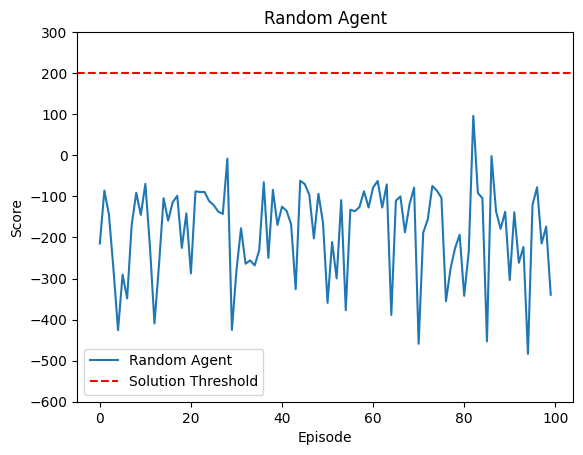

In [15]:
# Plot random agent's scores over all episodes

import matplotlib.pyplot as plt

plt.plot(rand_scores, label = "Random Agent")
plt.axhline(y = 200, color = 'r', linestyle = 'dashed', label = "Solution Threshold")  
plt.ylim([-600,300])
plt.title("Random Agent")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend();

As the above graph shows, the random agent does not learn anything and seldom achieves a positive score on any attempt, as expected.

### Simple Reflex Agent ###

Next, we examine an agent who can fire its left and right thrusters in reaction to its horizontal position relative to the landing pad only if the lander is tilting or rotating in the same direction. 

In [23]:
class ReflexAgent(Agent):
    '''
    Inherits from general agent class, but 
    selects actions according to horizontal 
    and angular position and angular velocity
    '''
    def __init__(self, name = "reflex_agent"):
        Agent.__init__(self, name)

    def select_action(self, state):
        '''
        Select action according to horizontal and
        angular position and angular velocity
        '''
        # Set tolerances
        horiz_tolerance = 2.0
        angular_tolerance = 3.14 / 6        # 30 degrees
        upright = 3.14 / 2                  # 90 degrees
        right_angular_tolerance = upright - angular_tolerance  # 60 degrees
        left_angular_tolerance = upright + angular_tolerance   # 120 degrees
        ang_vel_tolerance = 0.1

        # Horizontal position
        x = state[0]

        # Angular position
        angle = state[4]

        # Angular velocity
        ang_vel = state[5]

        # If left of landing pad
        if ((x < -horiz_tolerance)         
            # and tilting left or
            and ((angle > (left_angular_tolerance))
            # spinning counter-clockwise
            or (ang_vel > ang_vel_tolerance))):

            # Then, fire left thruster
            action = LEFT
        
        # If right of landing pad
        elif ((x > horiz_tolerance)         
            # and tilting right or
            and ((angle < (right_angular_tolerance))
            # spinning clockwise
            or (ang_vel < -ang_vel_tolerance))):
            
            # Then, fire right thruster
            action = RIGHT
        
        else:
            # Do nothing
            action = NOOP
        
        return action 

In [24]:
# Instantiate lunar lander reflex agent
rflx_agent = ReflexAgent()

# Iterate over 100 episodes
rflx_scores = rflx_agent.iterate(episodes, verbose = False, video = False)

# Print average max, min
average, max, min = rflx_agent.score_stats(verbose = True)


Average score: -135.76963525976183; Max: -2.7733466088406544; Min: -270.4331423001463


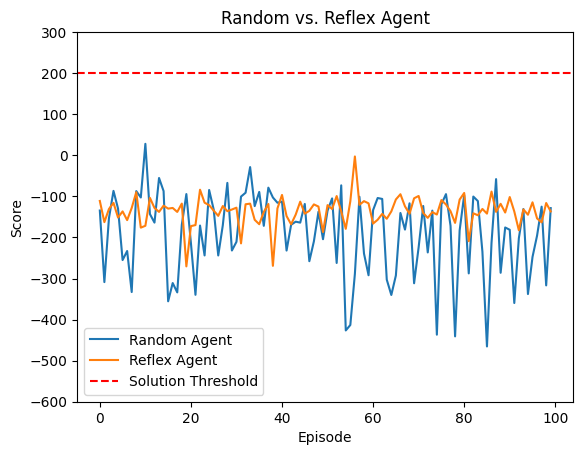

In [25]:
# Plot reflex and random agents' scores over all episodes

plt.plot(rand_scores, label = "Random Agent")
plt.plot(rflx_scores, label = "Reflex Agent")
plt.axhline(y = 200, color = 'r', linestyle = 'dashed', label = "Solution Threshold")  
plt.ylim([-600,300])
plt.title("Random vs. Reflex Agent")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend();

In the above graph, we can see that the reflex agent is more consistent than the random agent and also has a slightly higher average score, but it also did not improve over successive episodes, as expected. Landing a lunar rover appears to be more difficult than firing the left and right thrusters based on horizontal and angular position and angular velocity. It might be possible to adjust the algorithm to achieve a higher score, but this would be a tedious process, so we would like to find a more expedient way to find the best policy to follow.

### Q-Learning Agent ###

### Approximate Reinforcement Leaning Agent ###

## Discussion ## 

Does it include discussion (what went well or not and why), and suggestions for improvements or future work?

## Suggestions for Future Research ##




## References ##

Gymnasium. (2022). _Gymnasium documentation._ Farama Foundation. [https://gymnasium.farama.org/](https://gymnasium.farama.org/)

Russell, S., & Norvig, R. (2022). Artificial intelligence: A modern approach, (4th ed.). Pearson. 

Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT Press.